In [36]:
import mlflow

mlflow.set_tracking_uri("http://aiserver.tzp.haw-landshut.de:5050")
mlflow.set_experiment("RandomForestClassifier_paperd")

logged_model = 'runs:/edb83ffbcf5c459c833dd1d3d639b832/randomForest'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# 1. Parse files

In [20]:
import os
import json
import re
import numpy as np

def parse_acceleration_data(folder_path):
    """
    Parses acceleration data from JSON files in a folder.

    Args:
        folder_path (str): Path to the folder containing the JSON files.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing the acceleration data and the labels.

    Raises:
        ValueError: If the JSON files do not contain acceleration data with the expected format
                    or if the labels cannot be extracted from the filenames.
    """
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    num_files = len(file_names)
    acceleration_data = np.empty((num_files, 40000, 3))
    labels = np.empty((num_files, 1), dtype=np.object)

    for i, file_name in enumerate(file_names):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            json_data = json.load(file)

        if 'x' not in json_data or 'y' not in json_data or 'z' not in json_data:
            raise ValueError(f'Acceleration data not found in {file_path}')

        x_values = json_data['x']
        y_values = json_data['y']
        z_values = json_data['z']

        if len(x_values) != 40000 or len(y_values) != 40000 or len(z_values) != 40000:
            raise ValueError(f'Acceleration data size mismatch in {file_path}')

        acceleration_data[i] = np.array([x_values, y_values, z_values]).T

        # Extract label from the filename using regular expressions
        match = re.search(r'_scenario_(.*?)\.json', file_name)
        if match is None:
            raise ValueError(f'Label extraction error in {file_path}')

        label = match.group(1)
        print(label)
        labels[i] = label

    return acceleration_data, labels


data = parse_acceleration_data("./woodenInsertData/20230525/")

In [21]:
folder_path = './woodenInsertData/20230525/'

try:
    acceleration_array, labels = parse_acceleration_data(folder_path)
    print(acceleration_array.shape)  # Output the shape of the acceleration array
    print(labels.shape)  # Output the shape of the labels array
except ValueError as e:
    print(f'Error: {e}')

/tmp/ipykernel_16922/4029045582.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.empty((num_files, 1), dtype=np.object)


movingtable
liftingandlowering
largeloadcarriertrolley
movingtable
sacktrolley
palletjack
liftingandlowering
movingtable
largeloadcarriertrolley
rollerconveyor
rotatehorizontally
liftingandlowering
rollerconveyor
rollerconveyor
sacktrolley
liftingandlowering
walking
palletjack
movingtable
largeloadcarriertrolley
sacktrolley
walking
largeloadcarriertrolley
movingtable
idle
walking
walking
rotatehorizontally
rotatehorizontally
palletjack
idle
movingtable
largeloadcarriertrolley
rollerconveyor
rotatehorizontally
liftingandlowering
movingtable
sacktrolley
idle
idle
largeloadcarriertrolley
sacktrolley
sacktrolley
sacktrolley
palletjack
palletjack
movingtable
liftingandlowering
palletjack
walking
liftingandlowering
rotatehorizontally
walking
walking
idle
idle
liftingandlowering
rotatehorizontally
rollerconveyor
sacktrolley
idle
idle
rotatehorizontally
sacktrolley
sacktrolley
palletjack
movingtable
rollerconveyor
idle
rotatehorizontally
idle
largeloadcarriertrolley
walking
liftingandlowering


In [23]:
labels.shape

(135, 1)

In [26]:
acceleration_array.shape

(135, 40000, 3)

In [27]:
acceleration_array

array([[[ 0.0686205 , -0.0467415 , -1.50220191],
        [ 0.092859  , -0.043875  , -1.49956942],
        [ 0.1272375 , -0.0266565 , -1.45458293],
        ...,
        [ 0.07394399, -0.1583595 , -1.02332091],
        [ 0.0324285 , -0.1256775 , -1.10050201],
        [ 0.0097695 , -0.0758745 , -1.24205244]],

       [[ 0.0318435 ,  0.22038899, -1.00575149],
        [ 0.037713  ,  0.21914099, -1.00374293],
        [ 0.0366795 ,  0.21670349, -1.00610244],
        ...,
        [-0.027144  ,  0.22222199, -1.05259049],
        [-0.015717  ,  0.21982349, -1.05329251],
        [-0.00819   ,  0.2113995 , -1.05697799]],

       [[ 0.389103  , -0.468936  , -0.87769496],
        [ 0.22894949, -0.39481649, -0.31662148],
        [ 0.09490649, -0.300807  , -0.98513997],
        ...,
        [-0.23604749,  0.52139097, -0.89251494],
        [-0.24729899,  0.52681196, -0.89972997],
        [-0.2115555 ,  0.48176697, -0.892905  ]],

       ...,

       [[ 0.10093199,  0.40655547, -1.38719094],
        [-0

# 2. Apply Feature Engineering (Low-pass + 60x feature Extraction)
I really should create a webservice that handles all the data processing like feature extraction via a Web Api...

In [28]:
import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)
    print("X:", X.shape)
    return filtered_accel_data

In [29]:
data = applyLowPassFilter(acceleration_array)

X: (135, 40000, 3)


In [30]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(accel_data):
    # Initialize the result array with zeros
    num_recordings = accel_data.shape[0]
    num_axes = 3
    num_features = 20
    features = np.zeros((num_recordings, num_axes, num_features))

    # Calculate the features for each axis and recording separately
    for recording in range(num_recordings):
        recording_data = accel_data[recording]

        for axis in range(num_axes):
            axis_data = recording_data[:, axis]

            max_value = np.max(axis_data)
            min_value = np.min(axis_data)
            abs_max_value = np.max(np.abs(axis_data))
            abs_min_value = np.min(np.abs(axis_data))
            mean_value = np.mean(axis_data)
            abs_energy_value = np.sum(np.square(axis_data))
            mean_abs_change_value = np.mean(np.abs(np.diff(axis_data)))
            cid_ce_value = np.sum(np.abs(np.diff(axis_data))) / (np.sum(np.abs(axis_data)) + 1e-9)
            std_value = np.std(axis_data)
            var_value = np.var(axis_data)
            count_above_mean_value = np.sum(axis_data > mean_value)
            count_below_mean_value = np.sum(axis_data < mean_value)
            first_position_of_max_value = np.argmax(axis_data)
            first_position_of_min_value = np.argmin(axis_data)
            max_count_value = np.sum(axis_data == max_value)
            min_count_value = np.sum(axis_data == min_value)
            has_large_std_value = int(std_value > np.percentile(axis_data, 95))
            skew_value = skew(axis_data)
            kurtosis_value = kurtosis(axis_data)
            variation_coefficient_value = np.std(axis_data) / np.mean(axis_data)

            # Add the features to the result array
            features[recording, axis] = np.array([
                max_value, min_value, abs_max_value, abs_min_value, mean_value,
                abs_energy_value, mean_abs_change_value, cid_ce_value, std_value,
                var_value, count_above_mean_value, count_below_mean_value,
                first_position_of_max_value, first_position_of_min_value,
                max_count_value, min_count_value, has_large_std_value, skew_value,
                kurtosis_value, variation_coefficient_value
            ])

    # Combine the features for all three axes
    features = features.reshape(num_recordings, -1)

    # Return the features as a NumPy array
    return features

In [31]:
data = extract_features(data)

In [32]:
data.shape

(135, 60)

In [33]:
import pandas as pd
dataDF = pd.DataFrame(data)

In [34]:
dataDF

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.829393,-0.750299,0.829393,9.988575e-06,0.015038,1223.836311,0.040993,0.296627,0.174269,0.030370,...,20559.0,19441.0,30363.0,30309.0,1.0,1.0,1.0,-0.163897,0.355897,-0.323628
1,0.086170,-0.114867,0.114867,2.686186e-08,0.002872,36.254976,0.001829,0.076671,0.029969,0.000898,...,16741.0,23259.0,37475.0,1614.0,1.0,1.0,1.0,0.586807,-1.131545,-0.666796
2,1.915820,-2.273439,2.273439,2.760775e-06,0.004672,3438.503036,0.075119,0.336712,0.293157,0.085941,...,20598.0,19402.0,30008.0,30001.0,1.0,1.0,1.0,-0.303124,1.337245,-0.720380
3,0.954146,-0.863263,0.954146,3.290700e-06,0.017124,1506.080195,0.045832,0.302608,0.193284,0.037359,...,20305.0,19695.0,13605.0,32105.0,1.0,1.0,1.0,-0.136732,0.426115,-0.394834
4,0.447082,-0.452930,0.452930,5.759615e-06,-0.053986,333.776742,0.012771,0.176917,0.073688,0.005430,...,19915.0,20085.0,30235.0,9110.0,1.0,1.0,1.0,-0.032941,1.276434,-0.188089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.956569,-1.335601,1.335601,7.961453e-07,-0.026786,1781.073635,0.076091,0.458204,0.209307,0.043809,...,19885.0,20115.0,10662.0,8081.0,1.0,1.0,1.0,0.064775,0.395601,-0.661726
131,1.367635,-1.594509,1.594509,5.680287e-07,-0.009276,1249.334724,0.060531,0.514866,0.176486,0.031147,...,20460.0,19540.0,36236.0,36225.0,1.0,1.0,1.0,-0.119432,9.330933,-0.465640
132,1.389742,-2.015424,2.015424,1.627685e-06,0.004773,2158.802982,0.060224,0.333966,0.232266,0.053947,...,20941.0,19059.0,11859.0,30351.0,1.0,1.0,1.0,-0.469104,0.949366,-0.688060
133,0.362576,-0.494226,0.494226,6.579839e-06,-0.049152,309.328484,0.011390,0.164202,0.072920,0.005317,...,19946.0,20054.0,20783.0,244.0,1.0,1.0,1.0,-0.058053,1.032909,-0.158764


In [38]:
ypred = loaded_model.predict(dataDF)

In [48]:
ypred = np.array([str(item) for item in ypred])  # Convert elements to strings
ypred = np.char.lower(np.char.replace(ypred, ' ', ''))

In [49]:
ypred.shape

(135,)

In [57]:
np.unique(ypred)

array(['idle', 'largeloadcarriertrolley', 'liftingandlowering',
       'palletjack', 'rollerconveyor', 'rotatehorizontally',
       'sacktrolley', 'walking'], dtype='<U23')

In [51]:
labels.shape

(135,)

In [52]:
labels = labels.reshape(135)

In [53]:

# Assuming you have the NumPy arrays ypred and labels with shape (135,)
input = {'predicted': ypred, 'actual': labels}
df = pd.DataFrame(input)

# Printing the DataFrame
print(df)


                   predicted                   actual
0                 palletjack              movingtable
1                    walking       liftingandlowering
2    largeloadcarriertrolley  largeloadcarriertrolley
3                 palletjack              movingtable
4                sacktrolley              sacktrolley
..                       ...                      ...
130  largeloadcarriertrolley               palletjack
131           rollerconveyor           rollerconveyor
132  largeloadcarriertrolley  largeloadcarriertrolley
133              sacktrolley              sacktrolley
134           rollerconveyor           rollerconveyor

[135 rows x 2 columns]


In [54]:
# Assuming you have the DataFrame named 'df' with columns 'predicted' and 'actual'

# Create a crosstab of 'predicted' and 'actual' columns
confusion_matrix = pd.crosstab(df['predicted'], df['actual'])

# Printing the confusion matrix
print(confusion_matrix)

actual                   idle  largeloadcarriertrolley  liftingandlowering  \
predicted                                                                    
idle                       15                        0                   3   
largeloadcarriertrolley     0                       15                   0   
liftingandlowering          0                        0                   8   
palletjack                  0                        0                   0   
rollerconveyor              0                        0                   0   
rotatehorizontally          0                        0                   0   
sacktrolley                 0                        0                   0   
walking                     0                        0                   4   

actual                   movingtable  palletjack  rollerconveyor  \
predicted                                                          
idle                               0           0               0   
largeloadcarrie

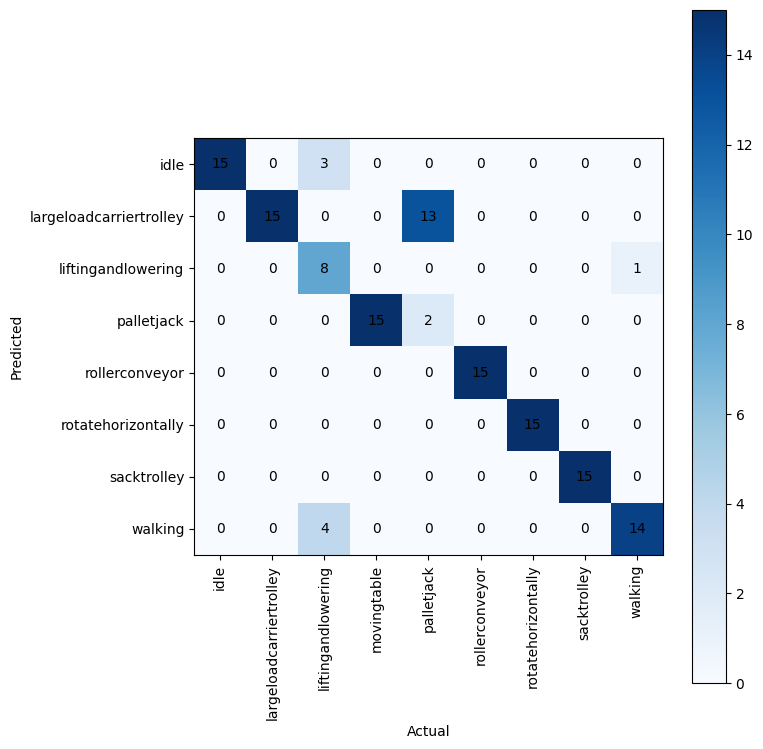

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have the confusion matrix stored in the variable 'confusion_matrix'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(confusion_matrix.shape[1]))
ax.set_yticks(np.arange(confusion_matrix.shape[0]))
ax.set_xticklabels(confusion_matrix.columns, rotation=90)
ax.set_yticklabels(confusion_matrix.index)

# Add values to the plot
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        text = ax.text(j, i, confusion_matrix.iloc[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


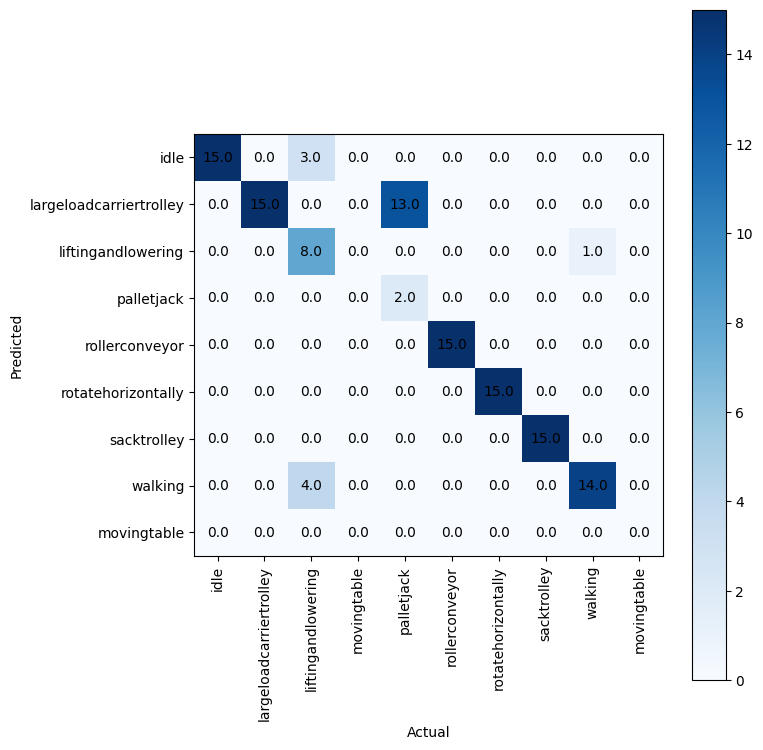

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have the confusion matrix stored in the variable 'confusion_matrix'

# Add an additional row and column for the "movingtable" label
confusion_matrix = confusion_matrix.reindex(index=confusion_matrix.index.append(pd.Index(["movingtable"])),
                                             columns=confusion_matrix.columns.append(pd.Index(["movingtable"])))
confusion_matrix.loc["movingtable", :] = 0
confusion_matrix.loc[:, "movingtable"] = 0

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(confusion_matrix.shape[1]))
ax.set_yticks(np.arange(confusion_matrix.shape[0]))
ax.set_xticklabels(confusion_matrix.columns, rotation=90)
ax.set_yticklabels(confusion_matrix.index)

# Add values to the plot
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        text = ax.text(j, i, confusion_matrix.iloc[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import confusion_matrix

# Assuming you have the NumPy arrays 'ypred' and 'labels'

# Create the confusion matrix
cm = confusion_matrix(labels, ypred)

# Printing the confusion matrix
print(cm)


[[15  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0]
 [ 3  0  8  0  0  0  0  0  4]
 [ 0  0  0  0 15  0  0  0  0]
 [ 0 13  0  0  2  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0 15  0]
 [ 0  0  1  0  0  0  0  0 14]]


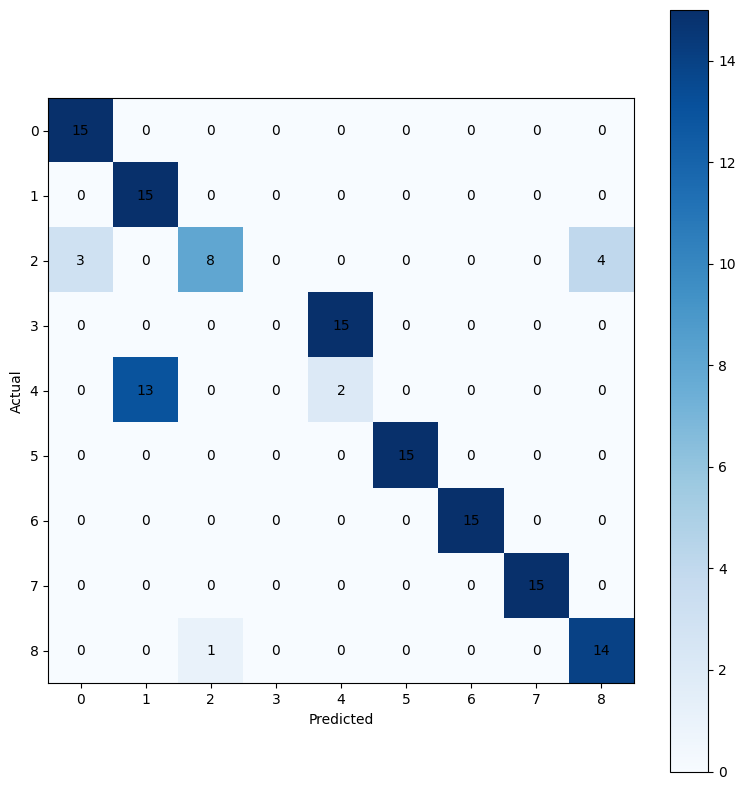

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

# Add values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


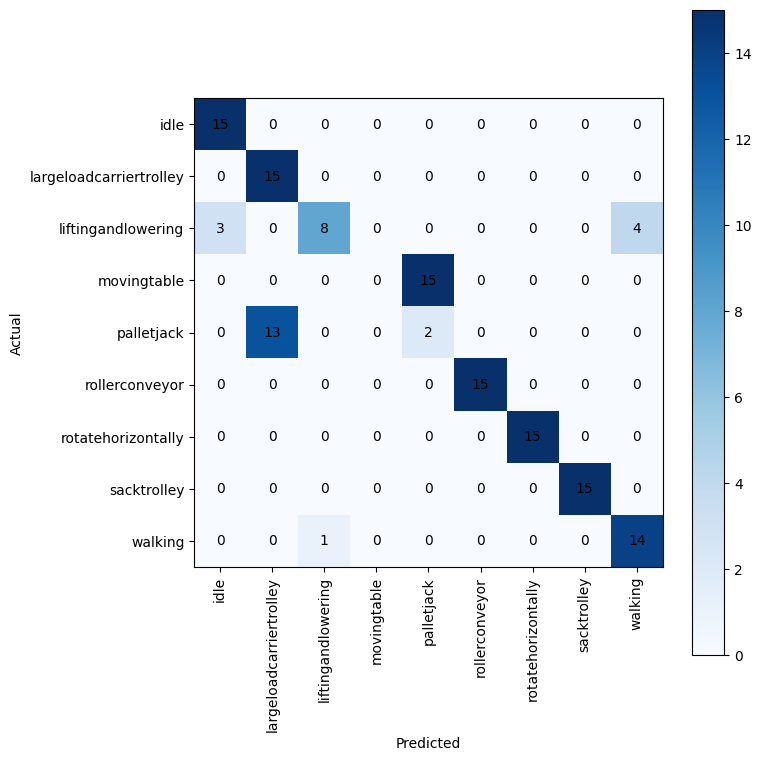

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'
# Assuming you have the 'labels' array with unique class labels

# Get the unique class labels from the confusion matrix
unique_labels = np.unique(labels)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(len(unique_labels)))
ax.set_yticks(np.arange(len(unique_labels)))
ax.set_xticklabels(unique_labels, rotation=90)
ax.set_yticklabels(unique_labels)

# Add values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


In [63]:
from sklearn.metrics import f1_score

# Assuming you have the true labels in the 'labels' array and the predicted labels in the 'ypred' array

# Calculate the F1-score
f1 = f1_score(labels, ypred, average='weighted')

# Print the F1-score
print("F1-score:", f1)


F1-score: 0.6941018714274528
